In [ ]:
import h5py
import numpy as np
import pandas as pd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Path to your .h5 data file
data_path = r"C:\Users\User\OneDrive - University of Bristol\Data Sci MSc\Summer Project\organised_data_new.h5"

# List to collect DataFrames per run for concatenation
dfs = []

with h5py.File(data_path, "r") as f:
    for enzyme in f.keys():
        # Class label
        is_carb = f[enzyme].attrs["carbapenemase"]
        enzyme_class = 'carbapenemase' if is_carb == 1 else 'non-carbapenemase'
        # Load sequence and compute residue count
        seq = list(f[enzyme].attrs["sequence"])
        n_res = len(seq)

        # Precompute native mask for selection
        aa_order = "ACDEFGHIKLMNPQRSTVWY"
        native_idx = np.array([aa_order.index(aa) for aa in seq])
        native_mask = np.zeros((20, n_res), dtype=float)
        native_mask[native_idx, np.arange(n_res)] = 1.0
        native_letters = np.array(seq)

        for run_group in f[enzyme].keys():
            # Load as Dask array: (n_frames, 20, n_res)
            ds = f[enzyme][run_group]["probs"]
            probs_ds = da.from_array(ds, chunks=(1000, 20, n_res))

            ambler_idx = f[enzyme][run_group]["ambler_idx"][:]        
            ins_rank   = f[enzyme][run_group]["ambler_ins_rank"][:]   

            # build mask: window and canonical-only
            mask = (ambler_idx >= 29) & (ambler_idx <= 287) & (ins_rank == 0)   
            if not np.any(mask):
                continue

            keep_idx    = np.where(mask)[0]                                 
            ambler_keep = ambler_idx[keep_idx]                              
            native_letters_keep = native_letters[keep_idx]     

            # load only kept positions
            probs_ds = da.from_array(ds[:, :, keep_idx], chunks=(1000, 20, len(keep_idx))) 
            probs_np = probs_ds.compute()              # (n_frames, 20, n_keep)
            n_frames, _, n_keep = probs_np.shape                             

            # also slice native arrays to kept columns
            native_mask_keep = native_mask[:, keep_idx]                     

            # Most-probable AA and features on the kept positions
            chosen_idx  = probs_np.argmax(axis=1)                # (n_frames, n_keep)
            aa_order    = np.array(list("ACDEFGHIKLMNPQRSTVWY"))
            chosen_flat = aa_order[chosen_idx.ravel()]           # (n_frames*n_keep,)

            native_flat = np.tile(native_letters_keep, n_frames)
            is_correct  = (chosen_flat == native_flat).astype(int)

            # features on kept columns
            native_p = np.sum(probs_np * native_mask_keep[np.newaxis, :, :], axis=1)   
            entropy  = -np.sum(probs_np * np.log(probs_np + 1e-9), axis=1)
            sorted_p = np.sort(probs_np, axis=1)[:, ::-1, :]
            gap      = sorted_p[:, 0, :] - sorted_p[:, 1, :]

            # flatten helpers use kept indices
            frame_idx   = np.repeat(np.arange(n_frames), n_keep)             
            raw_idx     = np.tile(keep_idx, n_frames)                     
            ambler_idx_f= np.tile(ambler_keep, n_frames)                    

            # Stack feature arrays into shape (n_frames*n_res, 3)
            data = np.stack([
                native_p.ravel(),
                entropy.ravel(),
                gap.ravel(),
                is_correct.ravel()
            ], axis=1)


            df_run = pd.DataFrame(
            data,
            columns=["native_p", "entropy", "max_minus_second", "is_correct"]
            )
            df_run["enzyme"]        = enzyme
            df_run["enzyme_class"]  = enzyme_class
            df_run["run"]           = run_group
            df_run["frame"]         = frame_idx
            df_run["residue_idx"]   = raw_idx
            df_run["ambler_idx"] = ambler_idx_f
            dfs.append(df_run)

# Concatenate all runs into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Quick summary
# print(df.head())
# print("Total records:", len(df))

In [ ]:
df_run = (
    df
    .groupby(['enzyme','enzyme_class','run','ambler_idx'])
    [['native_p','entropy', 'max_minus_second', 'is_correct']]
    .mean()
    .reset_index()
)

In [ ]:
df_run[df_run['ambler_idx'] == 104]

,enzyme,enzyme_class,run,residue_idx,ambler_idx,native_p,entropy,max_minus_second,is_correct
71,BlaC,non-carbapenemase,run_01,73,104,0.071269,2.128244,0.234002,0.0130
325,BlaC,non-carbapenemase,run_02,73,104,0.334571,1.529042,0.342559,0.4406
579,BlaC,non-carbapenemase,run_03,73,104,0.047849,1.387985,0.396569,0.0000
835,CTXM16,non-carbapenemase,run_01,78,104,0.049028,2.623524,0.070233,0.0000
1092,CTXM16,non-carbapenemase,run_02,78,104,0.050603,2.623349,0.064216,0.0000
1349,CTXM16,non-carbapenemase,run_03,78,104,0.049946,2.594875,0.067349,0.0000
1607,KPC2,carbapenemase,run_01,79,104,0.334086,2.295421,0.204045,0.8342
1864,KPC2,carbapenemase,run_02,79,104,0.376016,2.208992,0.244101,0.8916
2121,KPC2,carbapenemase,run_03,79,104,0.594187,1.674568,0.507961,0.9918
2378,NMCA,carbapenemase,run_01,77,104,0.009521,2.381268,0.109955,0.0000


C:\Users\User\AppData\Local\Temp\ipykernel_5300\4048121861.py:12: RuntimeWarning: invalid value encountered in scalar divide
  d_native = (a.mean() - b.mean()) / pooled_std
C:\Users\User\AppData\Local\Temp\ipykernel_5300\4048121861.py:17: RuntimeWarning: invalid value encountered in scalar divide
  d_entropy = (a2.mean() - b2.mean()) / pooled_std2
C:\Users\User\AppData\Local\Temp\ipykernel_5300\4048121861.py:22: RuntimeWarning: invalid value encountered in scalar divide
  d_is_correct = (a3.mean() - b3.mean()) / pooled_std3
C:\Users\User\AppData\Local\Temp\ipykernel_5300\4048121861.py:27: RuntimeWarning: invalid value encountered in scalar divide
  d_max_minus_second = (a4.mean() - b4.mean()) / pooled_std4


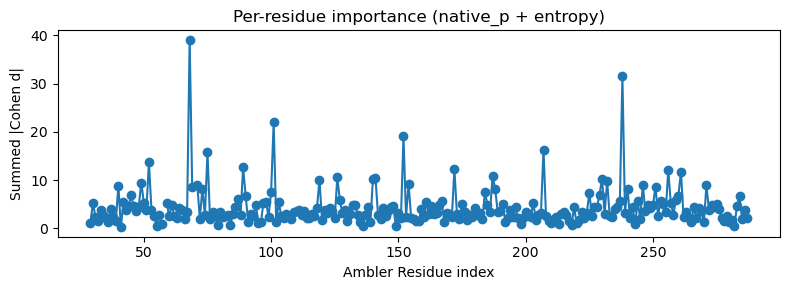

Top 15 important residues:


,d_native,d_entropy,d_is_correct,d_max_minus_second,importance
residue,,,,,
68,9.121637,2.694188,24.904239,2.350755,39.070820
238,9.378915,8.654204,4.212463,9.322336,31.567918
101,6.586499,5.613684,6.000521,3.801922,22.002625
152,8.774708,1.768542,6.750608,1.757174,19.051031
207,4.666516,4.444308,3.319434,3.882501,16.312758
75,4.667757,2.940324,5.057083,3.121329,15.786493
52,3.008870,2.884699,2.075668,5.690949,13.660186
89,3.518149,2.804213,4.199653,2.102140,12.624154
172,4.649706,1.603177,4.510210,1.479150,12.242242


In [ ]:
# 1) group into carb vs non‑carb
carb = df_run[df_run.enzyme_class=='carbapenemase']
non  = df_run[df_run.enzyme_class=='non-carbapenemase']

# 2) for each residue, compute Cohen's d for native_p and for entropy
results = []
for r in sorted(df_run.ambler_idx.unique()):
    a = carb.loc[carb.ambler_idx==r, 'native_p']
    b = non.loc[non.ambler_idx==r,   'native_p']
    # Cohen's d = (mean_a - mean_b) / pooled_std
    pooled_std = np.sqrt(((a.var(ddof=1) + b.var(ddof=1)) / 2))
    d_native = (a.mean() - b.mean()) / pooled_std

    a2 = carb.loc[carb.ambler_idx==r, 'entropy']
    b2 = non.loc[non.ambler_idx==r,   'entropy']
    pooled_std2 = np.sqrt(((a2.var(ddof=1) + b2.var(ddof=1)) / 2))
    d_entropy = (a2.mean() - b2.mean()) / pooled_std2

    a3 = carb.loc[carb.ambler_idx==r, 'is_correct']
    b3 = non.loc[non.ambler_idx==r,   'is_correct']
    pooled_std3 = np.sqrt(((a3.var(ddof=1) + b3.var(ddof=1)) / 2))
    d_is_correct = (a3.mean() - b3.mean()) / pooled_std3

    a4 = carb.loc[carb.ambler_idx==r, 'max_minus_second']
    b4 = non.loc[non.ambler_idx==r,   'max_minus_second']
    pooled_std4 = np.sqrt(((a4.var(ddof=1) + b4.var(ddof=1)) / 2))
    d_max_minus_second = (a4.mean() - b4.mean()) / pooled_std4

    results.append({
      'residue': r,
      'd_native': abs(d_native),
      'd_entropy': abs(d_entropy),
      'd_is_correct': abs(d_is_correct),
      'd_max_minus_second': abs(d_max_minus_second),
      'importance': abs(d_native) + abs(d_entropy) + abs(d_is_correct) + abs(d_max_minus_second)
    })

res_imp = pd.DataFrame(results).set_index('residue').sort_index()

# quick plot
plt.figure(figsize=(8,3))
plt.plot(res_imp.index, res_imp.importance, '-o')
plt.xlabel('Ambler Residue index')
plt.ylabel('Summed |Cohen d|')
plt.title('Per-residue importance (native_p + entropy)')
plt.tight_layout()
plt.show();

print("Top 15 important residues:")
res_imp.nlargest(15, 'importance')

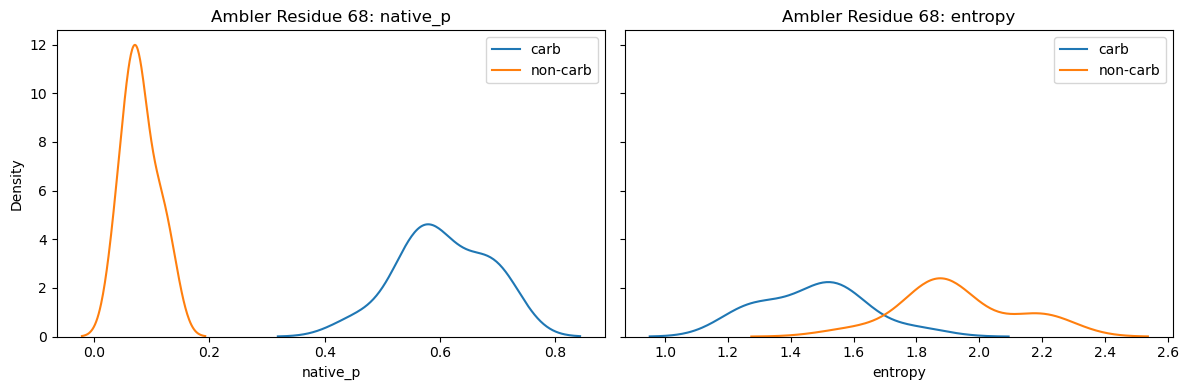

In [ ]:
r = 68

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
# Left: native_p
ax = axes[0]
sns.kdeplot(df_run.query("ambler_idx==@r and enzyme_class=='carbapenemase'")['native_p'], label='carb', ax=ax)
sns.kdeplot(df_run.query("ambler_idx==@r and enzyme_class=='non-carbapenemase'")['native_p'], label='non-carb', ax=ax)
ax.set_title(f'Ambler Residue {r}: native_p')
ax.set_xlabel('native_p')
ax.legend()
# Right: entropy
ax = axes[1]
sns.kdeplot(df_run.query("ambler_idx==@r and enzyme_class=='carbapenemase'")['entropy'], label='carb', ax=ax)
sns.kdeplot(df_run.query("ambler_idx==@r and enzyme_class=='non-carbapenemase'")['entropy'], label='non-carb', ax=ax)
ax.set_title(f'Ambler Residue {r}: entropy')
ax.set_xlabel('entropy')
ax.legend()
plt.tight_layout()
plt.show()

-------

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Assuming df is already loaded
# Aggregate per enzyme-run-residue: mean and std
agg = (
    df
    .groupby(['enzyme', 'enzyme_class', 'run', 'ambler_idx'])
    .agg(
        native_p_mean=('native_p', 'mean'),
        native_p_std=('native_p', 'std'),
        entropy_mean=('entropy', 'mean'),
        entropy_std=('entropy', 'std'),
        gap_mean=('max_minus_second', 'mean'),
        gap_std=('max_minus_second', 'std'),
        is_correct_mean=('is_correct', 'mean'),
        is_correct_std=('is_correct', 'std')
    )
    .reset_index()
)

# Pivot to have one row per enzyme-run, columns for each residue feature
pivot_native = agg.pivot_table(
    index=['enzyme', 'enzyme_class', 'run'],
    columns='ambler_idx',
    values='native_p_mean'
)
pivot_native.columns = [f'native_p_{i}' for i in pivot_native.columns]

# similar pivots for entropy_mean and gap_mean
en_pivot = agg.pivot_table(
    index=['enzyme', 'enzyme_class', 'run'],
    columns='ambler_idx',
    values='entropy_mean'
)
en_pivot.columns = [f'entropy_{i}' for i in en_pivot.columns]

gap_pivot = agg.pivot_table(
    index=['enzyme', 'enzyme_class', 'run'],
    columns='ambler_idx',
    values='gap_mean'
)
gap_pivot.columns = [f'gap_{i}' for i in gap_pivot.columns]

is_correct_pivot = agg.pivot_table(
    index=['enzyme', 'enzyme_class', 'run'],
    columns='ambler_idx',
    values='is_correct_mean'
)
is_correct_pivot.columns = [f'is_correct_{i}' for i in is_correct_pivot.columns]

# Combine into a single feature matrix
features = pd.concat([pivot_native, en_pivot, gap_pivot, is_correct_pivot], axis=1).reset_index()



In [175]:
feature_to_view = 'native_p_mean'

In [ ]:
# Statistical test per residue: compare carb vs non-carb for feature_to_view
residue_tests = []
for i in agg['ambler_idx'].unique():
    carb_vals = agg.loc[agg['enzyme_class']=='carbapenemase', feature_to_view][agg['ambler_idx']==i]
    non_vals = agg.loc[agg['enzyme_class']=='non-carbapenemase', feature_to_view][agg['ambler_idx']==i]
    t, p = ttest_ind(carb_vals, non_vals, equal_var=False)
    residue_tests.append({'ambler_idx': i, 't_stat': t, 'p_val': p})
res_tests_df = pd.DataFrame(residue_tests)

# Volcano plot data: mean diff vs -log10(p)
mean_diff = (
    agg.loc[agg['enzyme_class']=='carbapenemase'].groupby('ambler_idx')[feature_to_view].mean() -
    agg.loc[agg['enzyme_class']=='non-carbapenemase'].groupby('ambler_idx')[feature_to_view].mean()
)
res_tests_df['mean_diff'] = res_tests_df['ambler_idx'].map(mean_diff)
res_tests_df['neg_log10_p'] = -np.log10(res_tests_df['p_val'] + 1e-300)

# print(features.shape)
# print(res_tests_df.head())


c:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


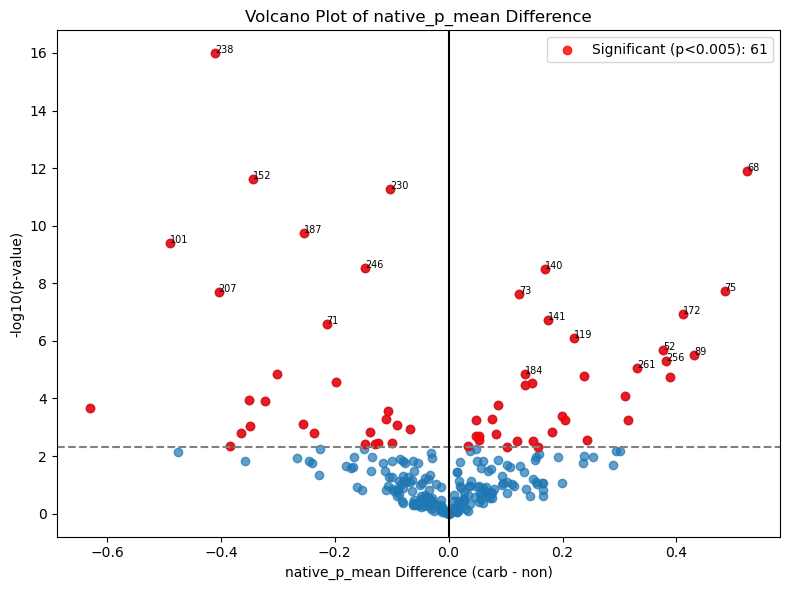

In [ ]:
# Assuming res_tests_df loaded

# Volcano plot
plt.figure(figsize=(8,6))
plt.scatter(res_tests_df['mean_diff'], res_tests_df['neg_log10_p'], alpha=0.7)

# Highlight significant residues (e.g. p<0.005)
sig_mask = res_tests_df['p_val'] < 0.005
n_sig = sig_mask.sum()
plt.scatter(
    res_tests_df.loc[sig_mask, 'mean_diff'],
    res_tests_df.loc[sig_mask, 'neg_log10_p'],
    color='red', alpha=0.8, label=f'Significant (p<0.005): {n_sig}')

plt.axhline(-np.log10(0.005), color='grey', linestyle='--')
plt.axvline(0, color='black', linestyle='-')
plt.xlabel(f'{feature_to_view} Difference (carb - non)')
plt.ylabel('-log10(p-value)')
plt.title(f'Volcano Plot of {feature_to_view} Difference')
plt.legend()
plt.tight_layout()

# # Annotate top residues
top_hits = res_tests_df.sort_values(['neg_log10_p','mean_diff'], ascending=False).head(20)
for _, row in top_hits.iterrows():
    plt.text(row['mean_diff'], row['neg_log10_p'], str(int(row['ambler_idx'])), fontsize=7)


plt.show()


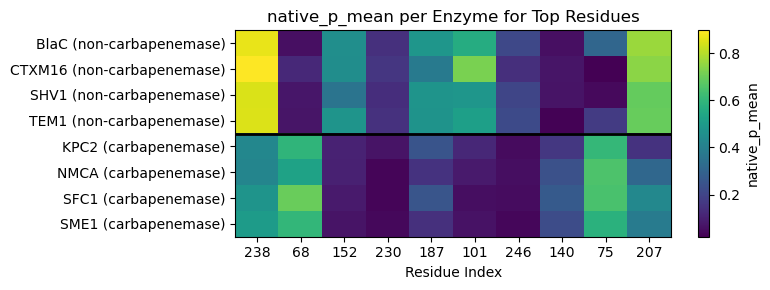

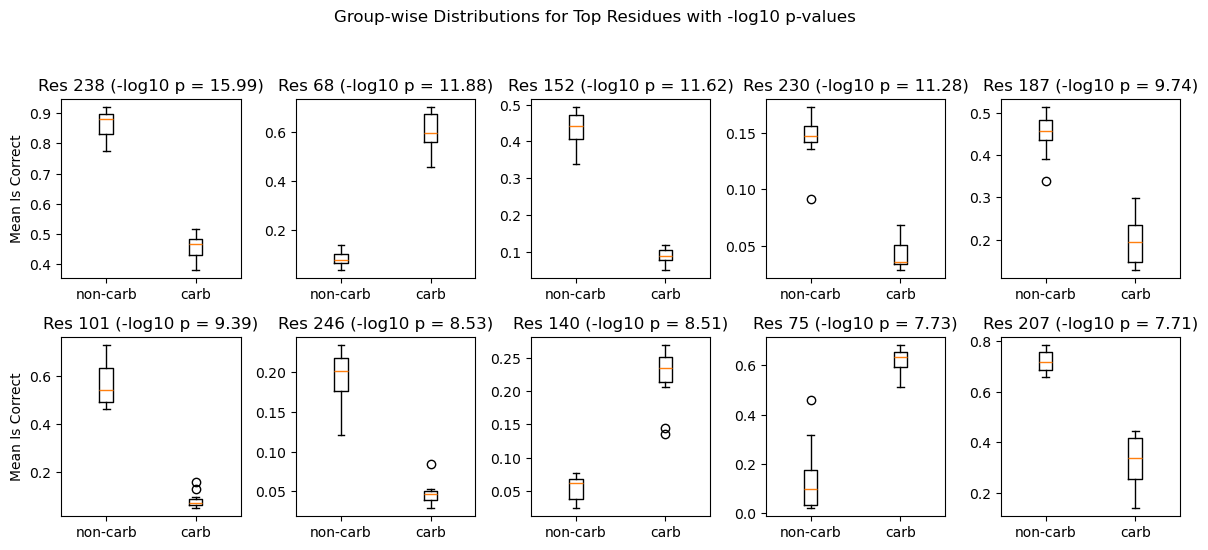

In [ ]:

# Identify top residues (e.g., top 10 by significance)
num_residues = 10
top_residues = (
    res_tests_df
    .sort_values('neg_log10_p', ascending=False)
    .head(num_residues)['ambler_idx']
    .astype(int)
    .tolist()
)

# Choose top residues by absolute effect size, subject to significance
# num_residues = 15
# p_cutoff = 0.0005

# top_residues = (
#     res_tests_df
#     .loc[res_tests_df['p_val'] < p_cutoff]
#     .assign(abs_diff=lambda d: d['mean_diff'].abs())
#     .sort_values('abs_diff', ascending=False)
#     .head(num_residues)['ambler_idx']
#     .astype(int)
#     .tolist()
# )

# Filter aggregated data for these residues
sel = agg[agg['ambler_idx'].isin(top_residues)].copy()

# Compute run-averaged per-enzyme means across runs
enzyme_group = (
    sel
    .groupby(['enzyme', 'enzyme_class', 'ambler_idx'])[feature_to_view]
    .mean()
    .reset_index()
)

# Pivot to have one row per enzyme
pivot = enzyme_group.pivot(
    index=['enzyme', 'enzyme_class'],
    columns='ambler_idx',
    values=feature_to_view
)

# Reorder enzymes: non-carbapenemase first, then carbapenemase
enzyme_order = [
    idx for idx in pivot.index
    if idx[1] == 'non-carbapenemase'
] + [
    idx for idx in pivot.index
    if idx[1] == 'carbapenemase'
]

pivot = pivot.reindex(enzyme_order)

# Prepare labels and data
enzymes = [f"{e} ({cls})" for e, cls in pivot.index]
data = pivot[top_residues].values

# Heatmap: one row per enzyme, labeled with carb status
plt.figure(figsize=(8, 3))
plt.imshow(data, aspect='auto', interpolation='nearest')
plt.colorbar(label=feature_to_view)
# Draw bold separator line between non-carb and carb groups
non_count = 4
plt.hlines(non_count - 0.5, xmin=-0.5, xmax=len(top_residues)-0.5, colors='black', linewidth=2)
plt.yticks(np.arange(len(enzymes)), enzymes)
plt.xticks(np.arange(len(top_residues)), top_residues)
plt.xlabel('Residue Index')
plt.title(f'{feature_to_view} per Enzyme for Top Residues')
plt.tight_layout()
plt.show()

# Boxplots per residue across enzyme classes:
to_plot = []
for r in top_residues:
    for enzyme, grp in sel.groupby('enzyme'):
        enzyme_class = grp['enzyme_class'].iloc[0]
        vals = grp[grp['ambler_idx'] == r][feature_to_view].values
        for v in vals:
            to_plot.append({
                'enzyme': enzyme,
                'enzyme_class': enzyme_class,
                'residue': r,
                feature_to_view: v
            })
box_df = pd.DataFrame(to_plot)

group_pvals = res_tests_df.set_index('ambler_idx')['neg_log10_p'].to_dict()

# Drilldown boxplots
plt.figure(figsize=(12, 8))
for i, r in enumerate(top_residues):
    ax = plt.subplot(3, 5, i+1)
    data_non = sel[(sel['ambler_idx'] == r) & (sel['enzyme_class'] == 'non-carbapenemase')][feature_to_view]
    data_carb = sel[(sel['ambler_idx'] == r) & (sel['enzyme_class'] == 'carbapenemase')][feature_to_view]
    ax.boxplot([data_non, data_carb], tick_labels=['non-carb', 'carb'])
    neglogp = group_pvals.get(r, np.nan)
    ax.set_title(f'Res {r} (-log10 p = {neglogp:.2f})')
    if i % 5 == 0:
        ax.set_ylabel('Mean Is Correct')
plt.suptitle('Group-wise Distributions for Top Residues with -log10 p-values')
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

--------------------

In [ ]:
import numpy as np
import pandas as pd
import h5py
import dask.array as da
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Build per-run summaries (each row = enzyme × run)
per_run_rows = []
cols = [
    'mean_native_p','std_native_p','max_prob',
    'mean_prob','std_prob',
    'mean_entropy','std_entropy',
    'mean_gap','std_gap',
    'prop_correct','std_prop_correct' 
]

data_path = r"C:\Users\User\OneDrive - University of Bristol\Data Sci MSc\Summer Project\organised_data_new.h5"

with h5py.File(data_path, 'r') as f:
    for enzyme in f:
        seq = list(f[enzyme].attrs['sequence'])
        aa_order = "ACDEFGHIKLMNPQRSTVWY"
        native_idx = np.array([aa_order.index(aa) for aa in seq]) 
        is_carb = f[enzyme].attrs['carbapenemase']
        class_label = 'carbapenemase' if is_carb==1 else 'non-carbapenemase'

        for run in f[enzyme]:
            arr = f[enzyme][run]['probs'][:]  # (n_frames, 20, N_res)

            # compute frame-level features
            mean_native_p = arr[:, native_idx, np.arange(arr.shape[2])].mean(axis=1)
            std_native_p  = arr[:, native_idx, np.arange(arr.shape[2])].std(axis=1)
            max_prob      = arr.max(axis=1).max(axis=1)

            sorted_p  = np.sort(arr, axis=1)[:, ::-1, :]
            mean_gap  = (sorted_p[:,0,:] - sorted_p[:,1,:]).mean(axis=1)
            std_gap   = (sorted_p[:,0,:] - sorted_p[:,1,:]).std(axis=1)

            flat      = arr.reshape(arr.shape[0], -1)
            mean_prob = flat.mean(axis=1)
            std_prob  = flat.std(axis=1)

            probs        = arr / (arr.sum(axis=1, keepdims=True) + 1e-8)
            ent_res      = -np.sum(probs * np.log(probs + 1e-8), axis=1)
            mean_entropy = ent_res.mean(axis=1)
            std_entropy  = ent_res.std(axis=1)

            chosen_idx = arr.argmax(axis=1)                          
            correct_mat = (chosen_idx == native_idx[None, :])        
            prop_correct = correct_mat.mean(axis=1)                 
            std_prop_correct = correct_mat.std(axis=1)               

            # stack into frame × feature, then average 
            feat_frames = np.vstack([
                mean_native_p, std_native_p, max_prob,
                mean_prob, std_prob,
                mean_entropy, std_entropy,
                mean_gap, std_gap,
                prop_correct, std_prop_correct
            ]).T

            feat_run_mean = feat_frames.mean(axis=0)  # 

            row = dict(zip(cols, feat_run_mean))
            row.update({'enzyme': enzyme, 'run': run, 'class_label': class_label})
            per_run_rows.append(row)

df_runs = pd.DataFrame(per_run_rows)   # one row per run

# Build per-enzyme summaries (each row = enzyme)
df_enzyme = (
    df_runs
    .groupby(['enzyme', 'class_label'], as_index=False)[cols]
    .mean()
)


Explained variance ratio: [0.8809659 0.1074096]


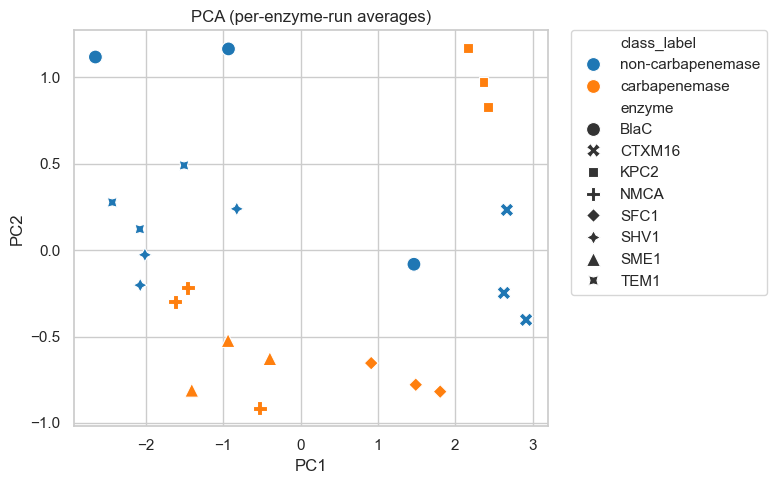

In [ ]:

# 3. Standardize features and run PCA
features = ['mean_native_p', 'mean_entropy','mean_gap', 'prop_correct']
X_scaled = StandardScaler().fit_transform(df_runs[features])   #  use df_runs for enzyme × run averages
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

df_runs[['pc1','pc2']] = pc

loadings_run = pd.DataFrame(
    pca.components_.T,         # shape (n_features, n_components)
    index=features,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# PCA scatter: colour by class, shape by enzyme
plt.figure(figsize=(8,5))
ax = sns.scatterplot(
    data=df_runs,
    x='pc1', y='pc2',
    hue='class_label',      # colour = class
    style='enzyme',         # shape = enzyme
    s=100
)
ax.set_title("PCA (per-enzyme-run averages)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


In [ ]:

# Load the combined HDF5 and sample frame-level features
enzyme_frame_data = []  # will hold feature arrays for each enzyme
enzyme_labels = []
enzyme_classes = []
data_path = r"C:\Users\User\OneDrive - University of Bristol\Data Sci MSc\Summer Project\organised_data_new.h5"

with h5py.File(data_path, 'r') as f:
    for enzyme in f.keys():
        # load sequence once per enzyme
        seq = list(f[enzyme].attrs['sequence'])
        aa_order = "ACDEFGHIKLMNPQRSTVWY"
        native_idx = np.array([aa_order.index(aa) for aa in seq]) 
        enzyme_labels.append(enzyme)
        is_carb = f[enzyme].attrs['carbapenemase']
        enzyme_classes.append('carbapenemase' if is_carb==1 else 'non-carbapenemase')
        run_feats = []
        for run in f[enzyme]:
            arr = f[enzyme][run]['probs'][:]  # (n_frames,20,N_res)

            # existing features
            mean_native_p = arr[:, native_idx, np.arange(arr.shape[2])].mean(axis=1)
            std_native_p  = arr[:, native_idx, np.arange(arr.shape[2])].std(axis=1)
            max_prob      = arr.max(axis=1).max(axis=1)

            sorted_p = np.sort(arr, axis=1)[:, ::-1, :]
            mean_gap = (sorted_p[:, 0, :] - sorted_p[:, 1, :]).mean(axis=1)
            std_gap  = (sorted_p[:, 0, :] - sorted_p[:, 1, :]).std(axis=1)

            flat = arr.reshape(arr.shape[0], -1)
            mean_prob = flat.mean(axis=1)
            std_prob  = flat.std(axis=1)

            probs = arr / (arr.sum(axis=1, keepdims=True) + 1e-8)
            ent_res = -np.sum(probs * np.log(probs + 1e-8), axis=1)
            mean_entropy = ent_res.mean(axis=1)
            std_entropy  = ent_res.std(axis=1)

            chosen_idx = arr.argmax(axis=1)                        
            correct_mat = (chosen_idx == native_idx[None, :])       
            prop_correct = correct_mat.mean(axis=1)             
            std_prop_correct = correct_mat.std(axis=1)             

            # stack features
            feat = np.vstack([
                mean_native_p, std_native_p, max_prob,
                mean_prob, std_prob,
                mean_entropy, std_entropy,
                mean_gap, std_gap,
                prop_correct,           
                std_prop_correct        
            ]).T

            run_feats.append(feat)

        enzyme_feat = np.vstack(run_feats)
        enzyme_frame_data.append(enzyme_feat)

# Combine into single DataFrame 
df_all = pd.DataFrame(
    np.vstack(enzyme_frame_data),
    columns=[
        'mean_native_p','std_native_p','max_prob',
        'mean_prob','std_prob',
        'mean_entropy','std_entropy',
        'mean_gap','std_gap',
        'prop_correct','std_prop_correct'  
    ]
)

df_all['enzyme'] = np.repeat(enzyme_labels, enzyme_frame_data[0].shape[0])
df_all['class_label'] = np.repeat(enzyme_classes, enzyme_frame_data[0].shape[0])


Explained variance ratio: [0.74405124 0.20051501]

Top +ve contributors to PC1:
mean_native_p    0.536009
mean_gap         0.516352
prop_correct     0.449237
mean_entropy    -0.494228
Name: PC1, dtype: float64

Top +ve contributors to PC2:
prop_correct     0.673514
mean_entropy     0.520716
mean_native_p    0.317774
mean_gap        -0.417436
Name: PC2, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_5300\2992096419.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


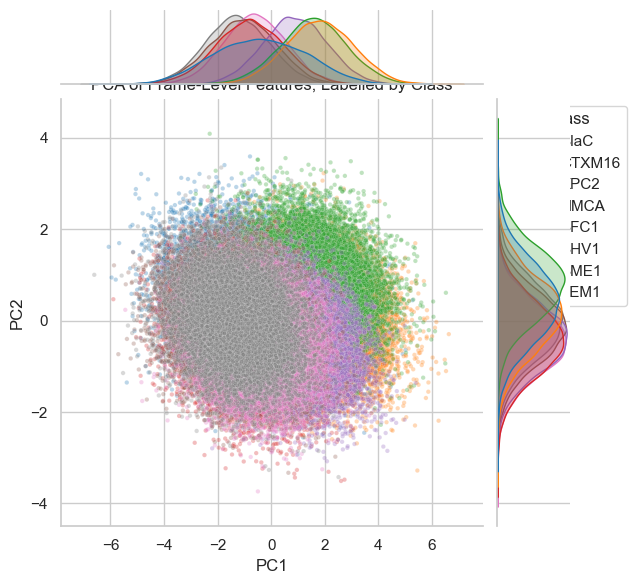

C:\Users\User\AppData\Local\Temp\ipykernel_5300\2992096419.py:53: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


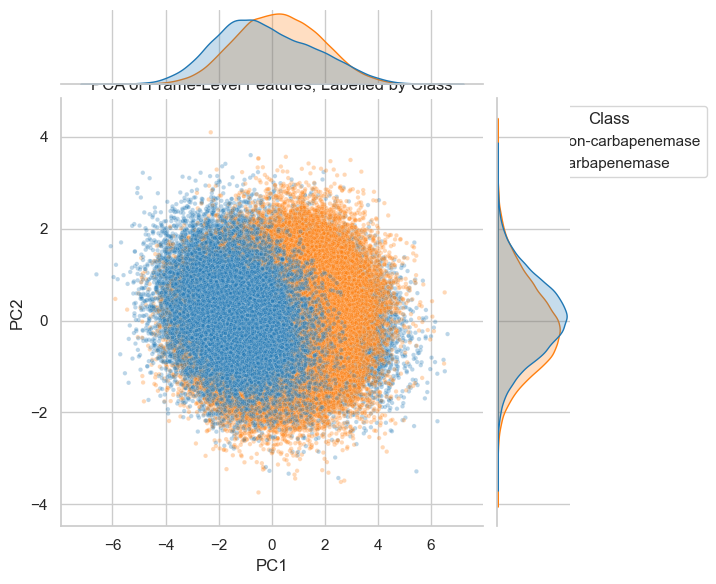

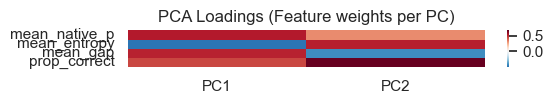

In [ ]:

# 3. Standardize features and run PCA
features = ['std_native_p','mean_gap','mean_entropy', 'mean_entropy']
features = ['mean_native_p','mean_entropy','mean_gap', 'prop_correct']
X_scaled = StandardScaler().fit_transform(df_all[features])
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

df_all[['pc1','pc2']] = pc
# df_all[['pc1','pc2', 'pc3']] = pc

loadings = pd.DataFrame(
    pca.components_.T,         # shape (n_features, n_components)
    index=features,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Look at the largest‐magnitude loadings per PC
# for pc in loadings.columns:
#     print(f"\nTop +ve contributors to {pc}:")
#     print(loadings[pc].nlargest(5))
    # print(f"Top -ve contributors to {pc}:")
    # print(loadings[pc].nsmallest(5))

# map class labels to integers
label_map = {'non-carbapenemase': 0, 'carbapenemase': 1}
y = df_all['class_label'].map(label_map).values

# PCA scatter by class
sns.jointplot(x='pc1', y='pc2', hue='enzyme', data=df_all, alpha=0.3, s=10)
plt.title('PCA of Frame-Level Features, Labelled by Class')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Class', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show();

# PCA scatter by class
sns.jointplot(x='pc1', y='pc2', hue='class_label', data=df_all, alpha=0.3, s=10)
plt.title('PCA of Frame-Level Features, Labelled by Class')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Class', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show();

# 3D PCA scatter plot
# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111, projection='3d')
# classes = df_all['enzyme'].unique()
# palette = dict(zip(classes, sns.color_palette(n_colors=len(classes))))
# for cls in classes:
#     sub = df_all[df_all['enzyme']==cls]
#     ax.scatter(sub['pc1'], sub['pc2'], sub['pc3'],
#                label=cls, alpha=0.5, s=10, c=[palette[cls]])
# ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
# ax.legend(title='Class', bbox_to_anchor=(1.05,1))
# plt.title('3D PCA of Frame-Level Features by Class')
# plt.tight_layout()
# plt.show();

plt.figure(figsize=(6, len(features)*0.3))
sns.heatmap(loadings, center=0, cmap='RdBu_r')
plt.title('PCA Loadings (Feature weights per PC)')
plt.tight_layout()
plt.show()


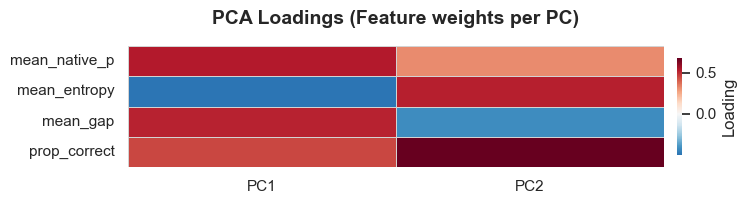

In [ ]:

# match the overall theme & palette
sns.set_theme(style="whitegrid", context="notebook")
sns.set_palette("tab10")  

plt.figure(figsize=(8, len(features) * 0.3 + 1))

# draw the heatmap with a slightly thinner grid & a compact colorbar
sns.heatmap(
    loadings,
    center=0,
    cmap="RdBu_r",
    linewidths=0.5,
    linecolor="lightgray",
    cbar_kws={
        "shrink": 0.8,
        "pad": 0.02,
        "label": "Loading"
    },
    xticklabels=1,
    yticklabels=1
)

plt.title(
    "PCA Loadings (Feature weights per PC)",
    pad=16,
    fontsize=14,
    weight="bold"
)

plt.tight_layout()
plt.show()


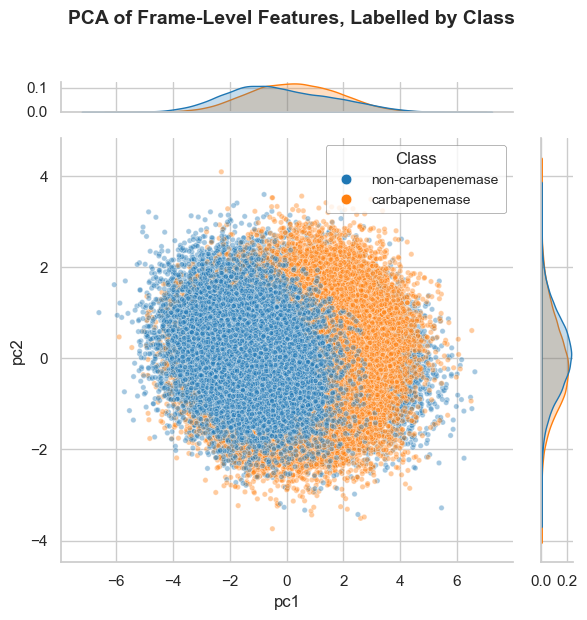

In [ ]:

sns.set_palette("tab10")

# draw the jointplot, passing style args directly
g = sns.jointplot(
    x='pc1', y='pc2',
    # hue='enzyme',    
    hue='class_label',
    data=df_all,
    height=6,
    ratio=8, 
    alpha=0.4,            # scatter alpha
    s=15,                 # scatter size
    edgecolor='w',        # white edge
    linewidth=0.5,        # edge thickness
    marginal_ticks=True,
)

# g.fig.set_size_inches(5, 5)

g.fig.suptitle(
    'PCA of Frame-Level Features, Labelled by Class',
    y=1.03,
    fontsize=14,
    weight='bold'
)
g.fig.tight_layout()

# get the handles/labels from the plot
handles, labels = g.ax_joint.get_legend_handles_labels()

for h in handles:
    try:
        h.set_alpha(1.0)
        h.set_sizes([80])     # increase legend-marker size
    except Exception:
        pass

# redraw the legend using the modified handles
leg = g.ax_joint.legend(
    handles, labels,
    title="Class",
    loc="upper right",
    scatterpoints=1,
    frameon=True,
    borderpad=0.5,
    markerscale=2,
    fontsize=10,
    title_fontsize=12
)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(0.5)

plt.show()
